# NetCDF Introduction: Part 2

## 1. Access the dataset for Visualization

In [1]:
import os

# ---- Specify directories below ----
download_folder = r"./era5-land-monthly/download"  # Folder for downloaded data
output_folder = r"./era5-land-monthly/output"      # Folder for final outputs
# ---- End of user inputs ----

# Create directories if they do not exist
os.makedirs(download_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

## 2. Read and Explore the data

In [2]:
# Specify the dataset filename and construct its full path
filename = "reanalysis-era5-land-monthly-means_2m_temperature_1950_2024.nc"
filepath = os.path.join(download_folder, filename)

# Display the constructed file path for verification
print(f"Dataset file path: {filepath}")

Dataset file path: ./era5-land-monthly/download\reanalysis-era5-land-monthly-means_2m_temperature_1950_2024.nc


## 3. Read Variable Data and Generate Basic Metadata

In [6]:
import netCDF4 as nc

# Open the NetCDF file in read mode
dataset = nc.Dataset(filepath, mode='r')

# List all variables in the dataset
variables_list = dataset.variables.keys()
print(f"Available variables: {list(variables_list)}")

# Extract coordinate data and the primary variable's data
lon_list = dataset['longitude'][:]  # Extract longitude
lat_list = dataset['latitude'][:]   # Extract latitude

Available variables: ['number', 'valid_time', 'latitude', 'longitude', 'expver', 't2m']


In [7]:
import pandas as pd

test_variable = 't2m'
variable_data = dataset[test_variable]

# Generate summary of the primary variable
summary = {
    "Variable Name": test_variable,
    "Data Type": variable_data.dtype,
    "Shape": variable_data.shape,
    "Variable Info": f"{test_variable}({', '.join(variable_data.dimensions)})",
    "Units": getattr(variable_data, "units", "N/A"),
    "Long Name": getattr(variable_data, "long_name", "N/A"),
}

# Display dataset summary as a DataFrame for better visualization
nc_summary = pd.DataFrame(list(summary.items()), columns=['Description', 'Remarks'])

# Display the summary DataFrame
nc_summary

,Description,Remarks
0,Variable Name,t2m
1,Data Type,float32
2,Shape,"(898, 3, 4)"
3,Variable Info,"t2m(valid_time, latitude, longitude)"
4,Units,K
5,Long Name,2 metre temperature


In [8]:
import numpy as np
import pandas as pd

# Configure pandas display settings for better readability
pd.set_option('display.max_colwidth', None)

# Create a summary of the dataset
ds_summary = {
    "Institution": dataset.institution if hasattr(dataset, 'institution') else "N/A",
    "Dimensions": list(dataset.dimensions.keys()),
    "Variables": list(dataset.variables.keys()),
    "Variable dimensions": [
        np.shape(dataset[variable]) for variable in dataset.variables.keys()
    ],
}

# Convert the summary dictionary into a DataFrame for better visualization
dataset_summary = pd.DataFrame(list(ds_summary.items()), columns=['Description', 'Remarks'])

# Display the summary DataFrame
dataset_summary

,Description,Remarks
0,Institution,European Centre for Medium-Range Weather Forecasts
1,Dimensions,"[valid_time, latitude, longitude]"
2,Variables,"[number, valid_time, latitude, longitude, expver, t2m]"
3,Variable dimensions,"[(), (898,), (3,), (4,), (898,), (898, 3, 4)]"


## 3. Creating a basic Plot for August 1980

In [9]:
# Define the target year and month for visualization
selected_year = 1980
selected_month = 8

# Calculate the band index for the selected year and month
# Index is determined by the position in the time dimension
band_index = (selected_year - 1950) * 12 + (selected_month - 1)

# Extract the data slice corresponding to the selected year and month
# This gives the spatial data (latitude x longitude) for the specified time
band_data = variable_data[band_index, :, :]

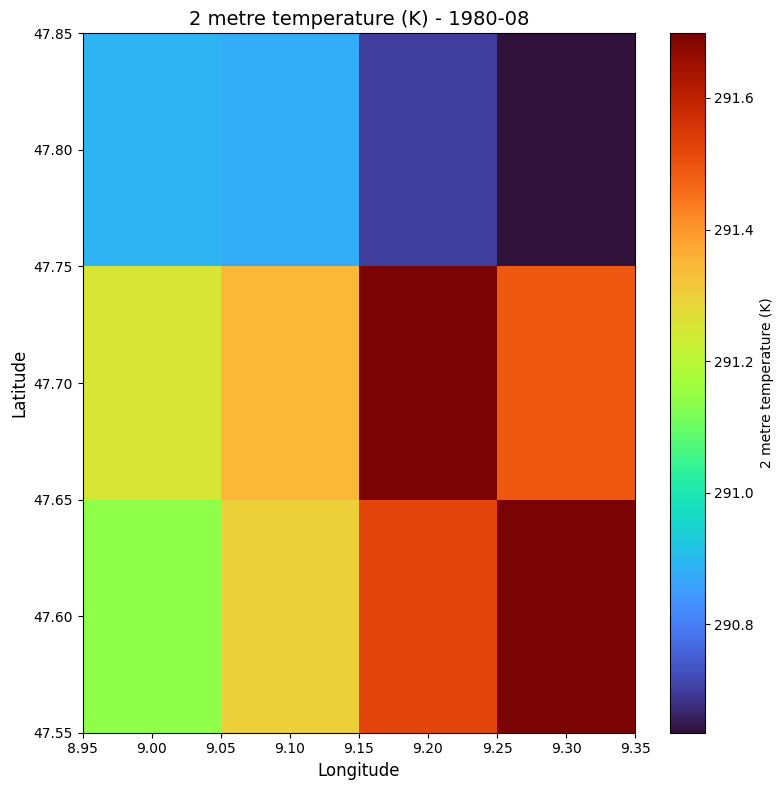

In [10]:
import matplotlib.pyplot as plt

# Plot the data using matplotlib
fig, ax = plt.subplots(figsize=(8, 8))

# Load predefined colormap
cmap = plt.get_cmap("turbo")

# Create a pseudo-color plot for the data
pcm = ax.pcolormesh(
    lon_list,
    lat_list,
    band_data,
    cmap=cmap,
    shading="auto",
)

# Add colorbar with units
cbar = plt.colorbar(pcm, ax=ax, label=f'{summary["Long Name"]} ({summary["Units"]})')

# Set plot title and labels
ax.set_title(
    f'{summary["Long Name"]} ({summary["Units"]}) - {selected_year}-{selected_month:02d}',
    fontsize=14,
)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

## 4. Create advanced Plot for August 1980

In [13]:
import numpy as np
import math as ma
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Convert the temperature data from Kelvin to °C
band_data_C = variable_data[band_index, :, :] - 273.15

# Calculate minimum and maximum values within the band data
vmin = np.nanmin(band_data_C)
vmax = np.nanmax(band_data_C)

vmin_floor = ma.floor(vmin * 10) / 10
vmax_ceil = ma.ceil(vmax * 10) / 10

# Compute interval for the color bar
interval = 0.1
bins = int((vmax_ceil - vmin_floor) / interval)

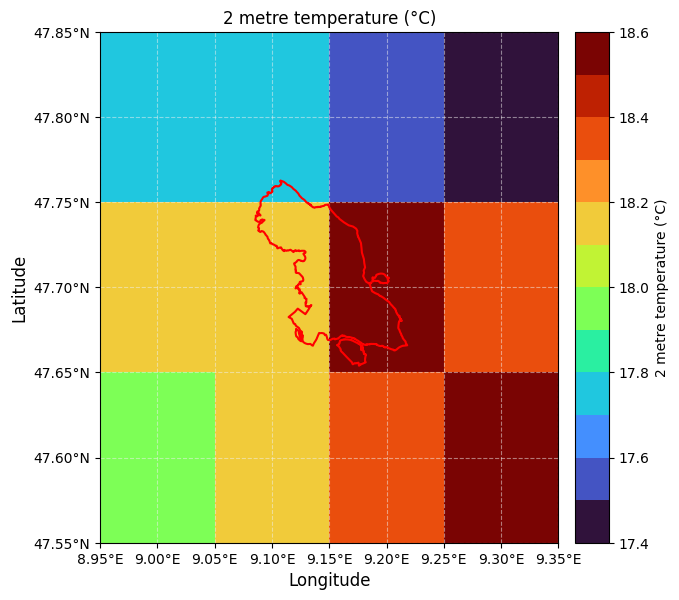

In [14]:
# Function to format latitude tick labels
def format_latitude(x, pos):
    return f"{x:.2f}°N"

# Function to format longitude tick labels
def format_longitude(x, pos):
    return f"{x:.2f}°E"

# Plot using matplotlib
fig, ax = plt.subplots(figsize=(8, 8))

# Load predefined Colormap with 10 discrete colors
cmap = plt.get_cmap('turbo', bins)

pcm = ax.pcolormesh(
    lon_list,
    lat_list,
    band_data_C,
    cmap=cmap,
    vmin=vmin_floor,
    vmax=vmax_ceil
)

# Add administrative boundary of Konstanz (Shapefile)
konstanz_shp = r"./shapefiles/kn_boundary.shp"
konstanz_boundary = gpd.read_file(konstanz_shp)
konstanz_boundary.boundary.plot(ax=ax, edgecolor='red')

# Plot color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95)
plt.colorbar(pcm, cax=cax, label=f'{summary["Long Name"]} (°C)')

# Add grid lines
ax.grid(visible=True, which='major', color='#f0f0f0', linestyle='--', alpha=0.5)

# Set custom tick formatters for latitude and longitude
ax.xaxis.set_major_formatter(FuncFormatter(format_longitude))
ax.yaxis.set_major_formatter(FuncFormatter(format_latitude))

ax.set_title(f'{summary["Long Name"]} (°C)')
ax.set_ylabel('Latitude', fontsize=12)
ax.set_xlabel('Longitude', fontsize=12)

# Display the plot
plt.show()

## 5. Create a Plot for a Time Series

In [15]:
# Initialize lists to store statistics
mean_values_list = []
median_values_list = []
std_values_list = []

# Calculate the total number of time bands
total_bands = range(variable_data.shape[0])

# Derive year and month lists based on the time index
year_list = [(band_index // 12) + 1950 for band_index in total_bands]
month_list = [(band_index % 12) + 1 for band_index in total_bands]

# Iterate over all bands to compute statistics
for band_index in total_bands:
    # Convert Kelvin to Celsius
    band_data = variable_data[band_index, :, :] - 273.15

    # Compute and append statistics
    mean_values_list.append(np.nanmean(band_data))  # Mean excluding NaNs
    median_values_list.append(np.ma.median(band_data))  # Median for masked arrays
    std_values_list.append(np.nanstd(band_data))  # Standard deviation excluding NaNs

# Create a dictionary to store results
df_data = {
    'Year': year_list,
    'Month': month_list,
    'Mean': mean_values_list,
    'Median': median_values_list,
    "Std Dev": std_values_list
}

# Convert dictionary to DataFrame
df_statistics = pd.DataFrame(df_data)

# Display the first few rows of the DataFrame
df_statistics.head()

,Year,Month,Mean,Median,Std Dev
0,1950,1,-1.677588,-1.677588,0.263794
1,1950,2,2.095921,2.076715,0.314301
2,1950,3,4.579808,4.523981,0.255085
3,1950,4,7.100448,7.199243,0.331744
4,1950,5,14.580113,14.644403,0.342235


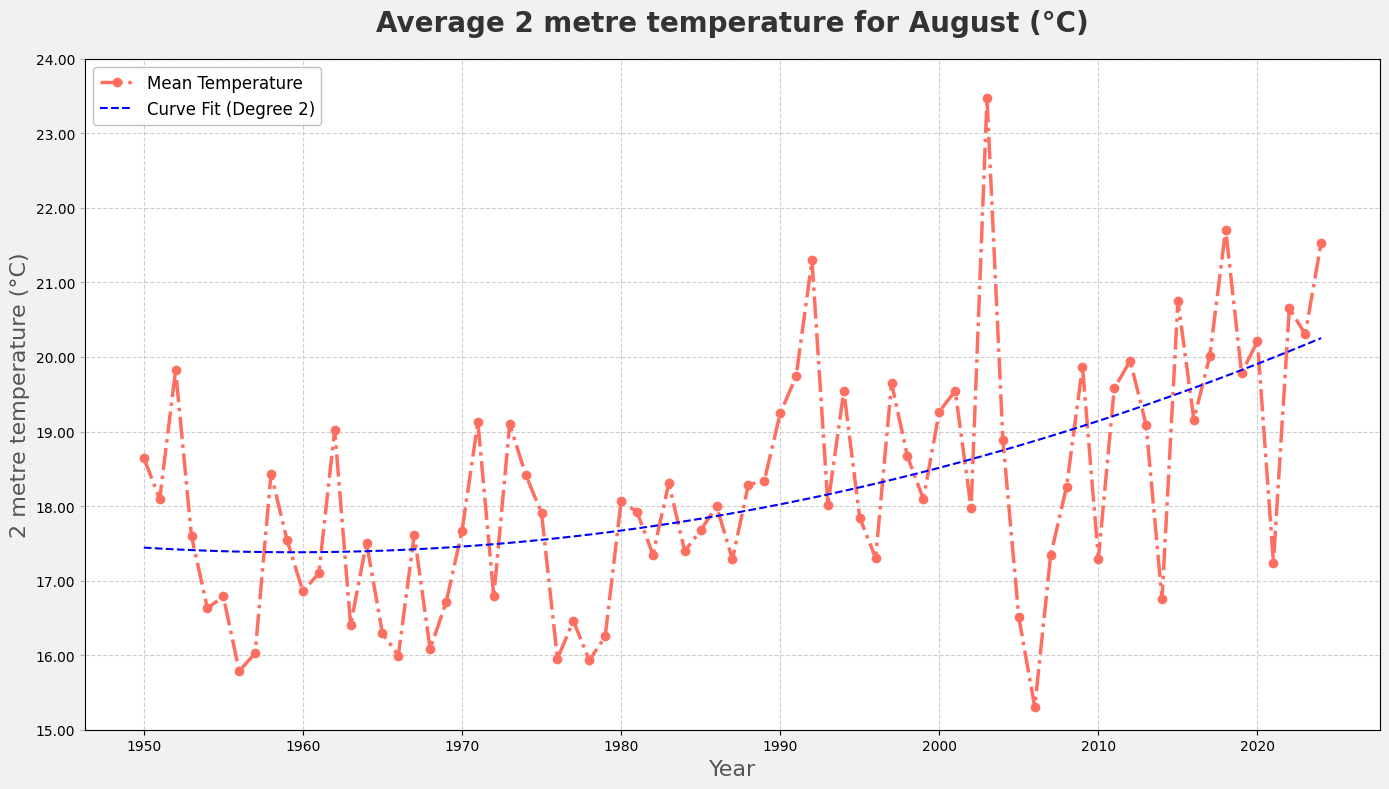

In [16]:
import matplotlib.ticker as ticker

# Filter the statistics DataFrame by the selected month (August)
selected_month = 8  # August
df_statistics_filtered = df_statistics[df_statistics['Month'] == selected_month]

# Initialize the plot
fig, ax = plt.subplots(figsize=(14, 8), facecolor='#f1f1f1')

# Titles and labels
ax.set_title(
    f'Average {summary["Long Name"]} for August (°C)',
    fontsize=20,
    fontweight='bold',
    color='#333333',
    pad=20
)
ax.set_xlabel("Year", fontsize=16, color='#555555')
ax.set_ylabel(f'{summary["Long Name"]} (°C)', fontsize=16, color='#555555')

# Update plot parameters for consistency
params = {
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
}
plt.rcParams.update(params)

# Add grid and tick formatting
ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
ax.tick_params(axis='y', which='both', color='#b0b0b0')

# Define y-axis limits
ax.set_ylim(15, 24)

# Plot the mean temperature trend
line1, = ax.plot(
    df_statistics_filtered['Year'],
    df_statistics_filtered['Mean'].astype(float),
    label='Mean Temperature',
    color='#ff6f61',
    linestyle='-.',
    marker='o',
    linewidth=2.5
)

# Fit a quadratic curve (degree 2) for the trend line
degree = 2  # Quadratic fit
coefficients = np.polyfit(
    df_statistics_filtered['Year'],
    df_statistics_filtered['Mean'].astype(float),
    degree
)
curve_fit = np.poly1d(coefficients)

# Plot the curve fit trend line
ax.plot(
    df_statistics_filtered['Year'],
    curve_fit(df_statistics_filtered['Year']),
    label=f'Curve Fit (Degree {degree})',
    color='blue',
    linestyle='--',
    linewidth=1.5
)

# Add legend
ax.legend(loc='upper left', fontsize=12, frameon=True, facecolor='#ffffff', edgecolor='#b0b0b0')

# Display the plot
plt.tight_layout()
plt.show()